In [4]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
%matplotlib inline

In [8]:
from pyhive import hive

# Set python variables from environment variables
username = os.environ['USERNAME']
hive_host = os.environ['HIVE_SERVER2'].split(':')[0]
hive_port = os.environ['HIVE_SERVER2'].split(':')[1]

# create connection
conn = hive.connect(
    host=hive_host,
    port=hive_port,
)

# create cursor
cur = conn.cursor()

print(f"your username is {username}")
print(f"you are connected to {hive_host}:{hive_port}")

your username is elmalki
you are connected to iccluster044.iccluster.epfl.ch:10000


#### Istdaten Columns:

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

The data source above contains separate data for every day/year and is not complete. We should use HDFS to query it.

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/part_orc/istdaten` and `/data/sbb/orc/allstops`. Your notebook [prepare-env](../notebooks/prepare-env.md) contains the command needed to create the external tables `sbb_orc` and `sbb_stops_orc`.

Unfortunately, HDFS is not accessible. See homework 2 for preprocessing, but no further preprocessing is possible until it is available.

**All Istdaten Attributes**

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

**Essential Attributes for the Graph**

- `BETRIEBSTAG`: date of the trip
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

**Attributes used for identification/checks for the Graph**

- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `HALTESTELLEN_NAME`: name of the stop

**Attributes used for Risk Aversion**

- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `AN_PROGNOSE`: actual arrival time
- `AB_PROGNOSE`: actual departure time

**Potentially useless attributes**

- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated



In [12]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

username = os.environ['RENKU_USERNAME']
hiveaddr = os.environ['HIVE_SERVER2']
(hivehost,hiveport) = hiveaddr.split(':')
print("Operating as: {0}".format(username))

Operating as: elmalki


In [13]:
from pyhive import hive

# create connection
conn = hive.connect(host=hivehost, 
                    port=hiveport,
                    username=username) 
# create cursor
cur = conn.cursor()

In [14]:
### Create your database if it does not exist
query = """
CREATE DATABASE IF NOT EXISTS {0} LOCATION '/user/{0}/hive'
""".format(username)
cur.execute(query)

In [15]:
### Make your database the default
query = """
USE {0}
""".format(username)
cur.execute(query)

In [16]:
query = """
DROP TABLE IF EXISTS {0}.sbb_orc
""".format(username)
cur.execute(query)

In [17]:
query = """
CREATE EXTERNAL TABLE {0}.sbb_orc(
        betriebstag STRING,
        fahrt_bezeichner STRING,
        betreiber_id STRING,
        betreiber_abk STRING,
        betreiber_name STRING,
        produkt_id STRING,
        linien_id STRING,
        linien_text STRING,
        umlauf_id STRING,
        verkehrsmittel_text STRING,
        zusatzfahrt_tf STRING,
        faellt_aus_tf STRING,
        bpuic STRING,
        haltestellen_name STRING,
        ankunftszeit STRING,
        an_prognose STRING,
        an_prognose_status STRING,
        abfahrtszeit STRING,
        ab_prognose STRING,
        ab_prognose_status STRING,
        durchfahrt_tf STRING
    )
    PARTITIONED BY (year INTEGER, month INTEGER)
    STORED AS ORC
    LOCATION '/data/sbb/part_orc/istdaten'
""".format(username)
cur.execute(query)

In [18]:
query = """
   MSCK REPAIR TABLE {0}.sbb_orc
""".format(username)
cur.execute(query)

In [19]:
query = """
DESCRIBE {0}.sbb_orc
""".format(username)
cur.execute(query)
cur.fetchall()

[('betriebstag', 'string', ''),
 ('fahrt_bezeichner', 'string', ''),
 ('betreiber_id', 'string', ''),
 ('betreiber_abk', 'string', ''),
 ('betreiber_name', 'string', ''),
 ('produkt_id', 'string', ''),
 ('linien_id', 'string', ''),
 ('linien_text', 'string', ''),
 ('umlauf_id', 'string', ''),
 ('verkehrsmittel_text', 'string', ''),
 ('zusatzfahrt_tf', 'string', ''),
 ('faellt_aus_tf', 'string', ''),
 ('bpuic', 'string', ''),
 ('haltestellen_name', 'string', ''),
 ('ankunftszeit', 'string', ''),
 ('an_prognose', 'string', ''),
 ('an_prognose_status', 'string', ''),
 ('abfahrtszeit', 'string', ''),
 ('ab_prognose', 'string', ''),
 ('ab_prognose_status', 'string', ''),
 ('durchfahrt_tf', 'string', ''),
 ('year', 'int', ''),
 ('month', 'int', ''),
 ('', None, None),
 ('# Partition Information', None, None),
 ('# col_name', 'data_type', 'comment'),
 ('year', 'int', ''),
 ('month', 'int', '')]

In [20]:
query = """
SHOW PARTITIONS {0}.sbb_orc
""".format(username)
cur.execute(query)
cur.fetchall()

[('year=2018/month=1',),
 ('year=2018/month=10',),
 ('year=2018/month=11',),
 ('year=2018/month=12',),
 ('year=2018/month=2',),
 ('year=2018/month=3',),
 ('year=2018/month=4',),
 ('year=2018/month=5',),
 ('year=2018/month=6',),
 ('year=2018/month=7',),
 ('year=2018/month=8',),
 ('year=2018/month=9',),
 ('year=2019/month=1',),
 ('year=2019/month=10',),
 ('year=2019/month=11',),
 ('year=2019/month=12',),
 ('year=2019/month=2',),
 ('year=2019/month=3',),
 ('year=2019/month=4',),
 ('year=2019/month=5',),
 ('year=2019/month=6',),
 ('year=2019/month=7',),
 ('year=2019/month=8',),
 ('year=2019/month=9',),
 ('year=2020/month=1',),
 ('year=2020/month=10',),
 ('year=2020/month=11',),
 ('year=2020/month=12',),
 ('year=2020/month=2',),
 ('year=2020/month=3',),
 ('year=2020/month=4',),
 ('year=2020/month=5',),
 ('year=2020/month=6',),
 ('year=2020/month=7',),
 ('year=2020/month=8',),
 ('year=2020/month=9',),
 ('year=2021/month=1',),
 ('year=2021/month=10',),
 ('year=2021/month=11',),
 ('year=2021/m

In [21]:
query = """
    SELECT substr(betriebstag, 4) AS month_year,  lower(produkt_id) AS ttype, count(*) AS stops
    FROM {0}.sbb_orc
    WHERE
    year<2021
    AND year>2018
    AND betriebstag LIKE '__.__.____' AND produkt_id IS NOT NULL AND produkt_id <> ''
    GROUP BY substr(betriebstag, 4), lower(produkt_id)
    ORDER BY substr(month_year, 3), substr(month_year, 1, 2), ttype
""".format(username)
df_ttype = pd.read_sql(query, conn)

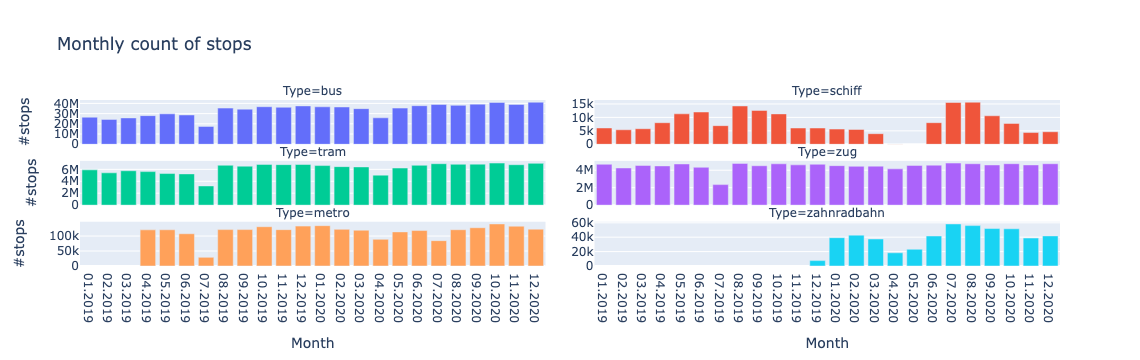

In [22]:
fig = px.bar(
    df_ttype, x='month_year', y='stops', color='ttype',
    facet_col='ttype', facet_col_wrap=2, 
    facet_col_spacing=0.05, facet_row_spacing=0.1,
    labels={'month_year':'Month', 'stops':'#stops', 'ttype':'Type'},
    title='Monthly count of stops'
)
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)
fig.show()

In [23]:
query="create view if not exists sbb_orc_201910 as (select * from sbb_orc where year=2019 and month=10)"
cur.execute(query)

query="""
    -- table of delays
    create view if not exists delays_201910 as (
        select 
            HALTESTELLEN_NAME as halt_name,
            greatest(0, unix_timestamp(AN_PROGNOSE, 'dd.MM.uuuu HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.uuuu HH:mm')) as arrv_delay
        from sbb_orc_201910
        where (upper(AB_PROGNOSE_STATUS) in ('REAL', 'GESCHAETZT') or upper(AN_PROGNOSE_STATUS) in ('REAL', 'GESCHAETZT')) 
        and lower(PRODUKT_ID)='zug'
    )"""
cur.execute(query)

query="""
    -- table of quantiles of delays
    create view if not exists quantile_delays_201910 as (
        select halt_name, percentile_approx(
            if(arrv_delay is NULL, 0, arrv_delay), 0.5) as q50
        from delays_201910
        group by halt_name
        having halt_name <> ''
    )
"""
cur.execute(query)

In [24]:
query="""
    -- inner join delays with sbb_stops_orc
    select *
    from quantile_delays_201910 inner join sbb_stops_orc 
        on (halt_name=STOP_NAME or halt_name=STOP_ID)
"""
df_1e = pd.read_sql(query, conn)
df_1e

quantile_delays_201910.halt_name  quantile_delays_201910.q50  \
0                                Moos                  199.500000   
1                                Moos                  199.500000   
2                                Moos                  199.500000   
3                             Lungern                   26.333333   
4                             Lungern                   26.333333   
...                               ...                         ...   
6361                           Bitsch                    0.000000   
6362                           Bitsch                    0.000000   
6363                           Bitsch                    0.000000   
6364                           Bitsch                    0.000000   
6365                           Bitsch                    0.000000   

     sbb_stops_orc.stop_id sbb_stops_orc.stop_name  sbb_stops_orc.stop_lat  \
0              8507084:0:1                    Moos               46.909990   
1                8507084:0                    Moos               46.909990   
2                  8507084                    Moos               46.909990   
3              8508310:0:1                 Lungern               46.786343   
4                8508310:0                 Lungern               46.786343   
...                    ...                     ...                     ...   
6361         Parent8501677                  Bitsch               46.336056   
6362              8501677P                  Bitsch               46.336063   
6363           8501677:0:2                  Bitsch               46.336063   
6364           8501677:0:1                  Bitsch               46.336063   
6365             8501677:0                  Bitsch               46.336063   

      sbb_stops_orc.stop_lon sbb_stops_orc.location_type  \
0                   7.401022                               
1                   7.401022                               
2                   7.401022                               
3                   8.163557                               
4                   8.163557                               
...                      ...                         ...   
6361                8.017221                           1   
6362                8.017221                           1   
6363                8.017221                               
6364                8.017221                               
6365                8.017221                               

     sbb_stops_orc.parent_station  
0                                  
1                                  
2                                  
3                                  
4                                  
...                           ...  
6361                               
6362                               
6363                Parent8501677  
6364                Parent8501677  
6365                Parent8501677  

[6366 rows x 8 columns]

In [25]:
df_1e = df_1e.rename(columns={colname:colname.split('.')[1] for colname in df_1e.columns})

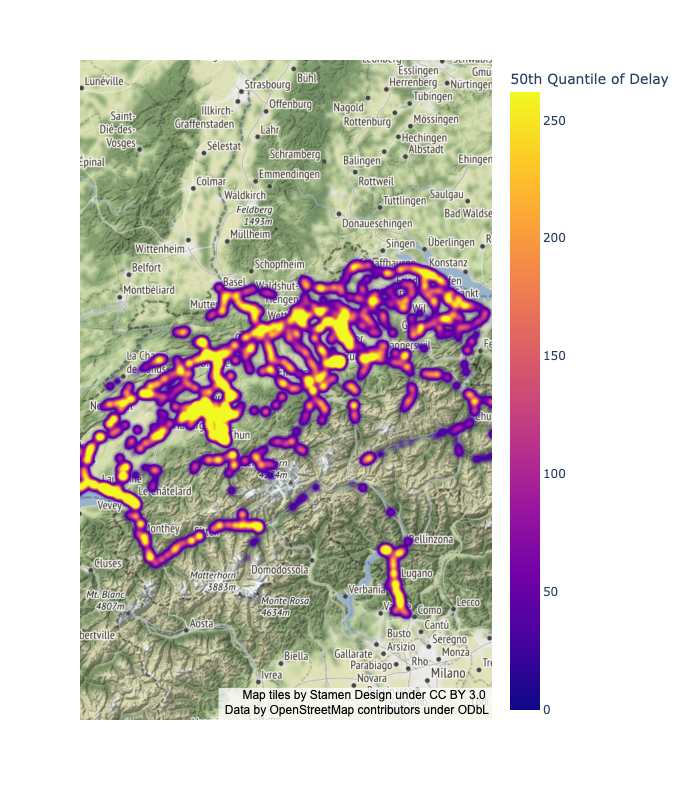

In [26]:
fig = px.density_mapbox(df_1e, lat='stop_lat', lon='stop_lon', z="q50", radius=8,
                        center=dict(lat=df_1e.stop_lat.mean(), lon=df_1e.stop_lon.mean()), zoom=6.5,
                        labels=dict(q50="50th Quantile of Delay"),
                        mapbox_style="stamen-terrain", height=800)
fig.show()